In [1]:
### imporitng lib

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
warnings.filterwarnings("ignore")

In [7]:
from causalnex.structure.notears import from_pandas
from causalnex.structure import StructureModel

In [9]:
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from sklearn.preprocessing import LabelEncoder
from causalnex.discretiser import Discretiser
from causalnex.network import BayesianNetwork
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score
from causalnex.inference import InferenceEngine

In [10]:
sns.set()
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)

In [13]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('../scripts')))

###### importing modules

In [17]:
from file import Myfile
from utils import Utils

In [18]:
file = Myfile()
utils = Utils()

###### Load data

load the data that prepared during EDA for the causal graph

In [21]:
#df = file.read_csv("../data/causaldata.csv")
df = file.read_csv("C:/Users/Ekubazgi/Desktop/data/causaldata.csv")

--> file read as csv


In [25]:
cols = ['Trip Start Time','Trip End Time']
df = df.drop(columns=cols)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1555718 entries, 0 to 1555717
Data columns (total 8 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Trip ID           1555718 non-null  int64  
 1   Trip Origin       1555718 non-null  object 
 2   Trip Destination  1555718 non-null  object 
 3   Distance          1555718 non-null  float64
 4   Speed             1555718 non-null  float64
 5   driver_action     1555718 non-null  object 
 6   is_weekend        1555718 non-null  int64  
 7   is_holiday        1555718 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 95.0+ MB


In [27]:
df.head(3)

,Trip ID,Trip Origin,Trip Destination,Distance,Speed,driver_action,is_weekend,is_holiday
0,392001,"6.6010417,3.2766339","6.4501069,3.3916154",20.98,217.00,accepted,0,0
1,392001,"6.6010417,3.2766339","6.4501069,3.3916154",20.98,217.00,rejected,0,0
2,392001,"6.6010417,3.2766339","6.4501069,3.3916154",20.98,217.00,rejected,0,0


In [28]:
df.shape

(1555718, 8)

###### Label Encoding
change catagorical variable to numeric variable

In [30]:
non_num_cols = list(df.select_dtypes(exclude=[np.number]).columns)
le = LabelEncoder()
for col in non_num_cols:
    df[col] = le.fit_transform(df[col])


In [31]:
df.head(3)

,Trip ID,Trip Origin,Trip Destination,Distance,Speed,driver_action,is_weekend,is_holiday
0,392001,11676,3785,20.98,217.00,0,0,0
1,392001,11676,3785,20.98,217.00,1,0,0
2,392001,11676,3785,20.98,217.00,1,0,0


In [32]:
# initializing the structural model
model = StructureModel()

In [33]:
#selecting the dataset used to construct the causal graph
x_df = df.tail(50000)

reaname the columns for further readablity

In [34]:
dict = {'Trip Origin': 'Tr_Origin',
        'Trip ID': 'Ord_id',
        'Trip Destination': 'Tr_Dest',
        }

x_df.rename(columns=dict,
          inplace=True)

In [35]:
model = from_pandas(x_df)

###### Visualization

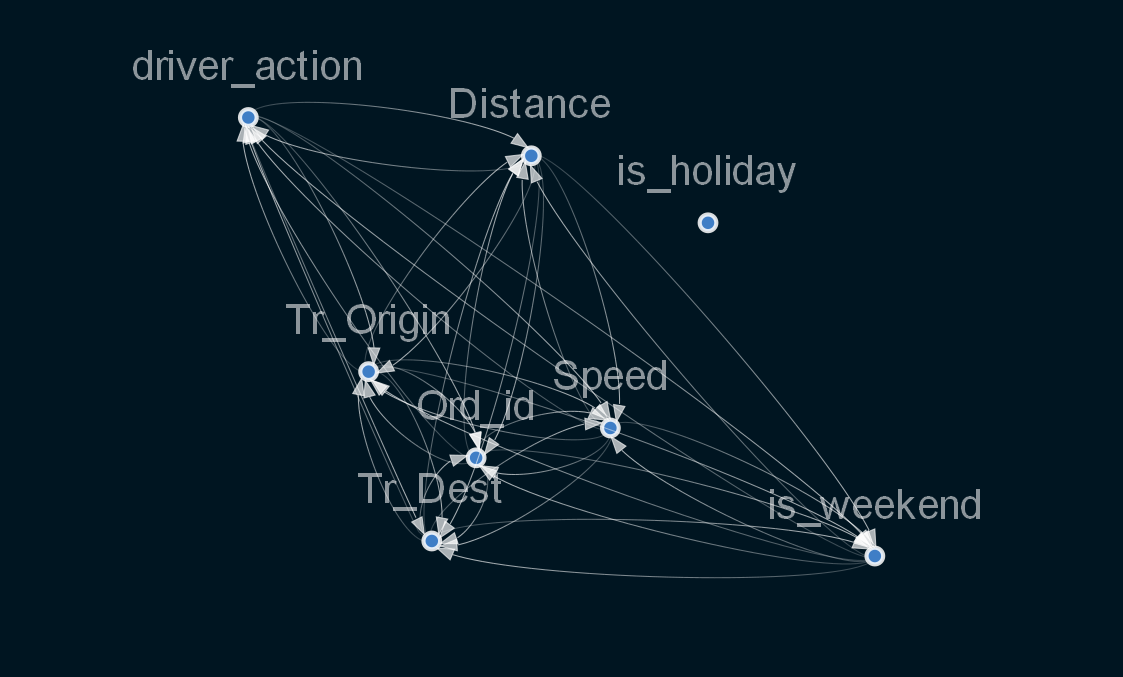

In [36]:
v = plot_structure(
    model,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
    prog='fdp',
)
Image(v.draw(format='png'))

###### removing edges with low threshold

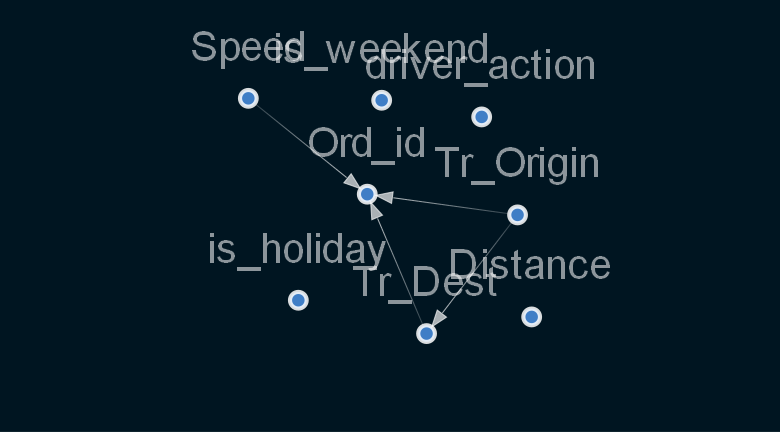

In [39]:
model.remove_edges_below_threshold(0.8)
v = plot_structure(
    model,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(v.draw(format='png'))

speed affects Order_id - orders may be delay.
Trip_origion and Trip_Destination also affects order id.

###### Stablity

In [41]:
#checking with 80%
portion = int(x_df.shape[0] *.80)
x_portion = x_df.head(portion)

CPU times: total: 9.05 s
Wall time: 3.84 s


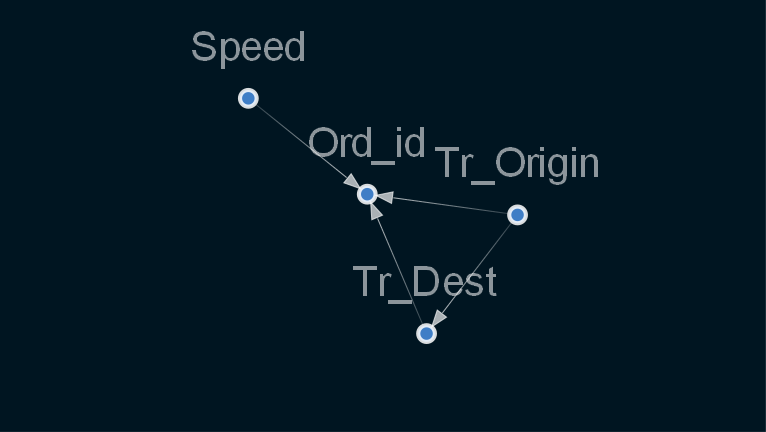

In [42]:
%%time
model1 = from_pandas(x_portion)
model1.remove_edges_below_threshold(0.8)
model1 = model1.get_largest_subgraph()
v = plot_structure(
    model1,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(v.draw(format='png'))

In [43]:
#checking with 95%
portion = int(x_df.shape[0] *.95)
x_portion = x_df.head(portion)

CPU times: total: 8.61 s
Wall time: 3.83 s


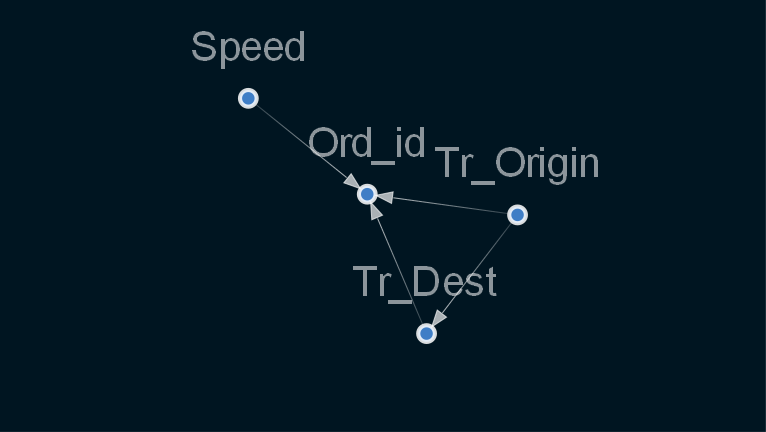

In [44]:
%%time
model2 = from_pandas(x_portion)
model2.remove_edges_below_threshold(0.8)

model2 = model1.get_largest_subgraph()
v = plot_structure(
    model2,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(v.draw(format='png'))

In [45]:
def jaccard_similarity(g,h):
    i = set(g).intersection(h)
    return round(len(i)/(len(g) + len(h) - len(i)),3)

In [46]:
jaccard_similarity(model2.edges, model1.edges)

1.0